In [214]:
import pandas as pd
import numpy as np
from geopy.distance import great_circle
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('twitter.csv')
# about 1% of rows are slightly out of order (few seconds behind the previous row). not sure if this is the "right" or "best" way to handle it
# but this method sorts data while preserving as much of the original data and row order as possible.
df['idx'] = df.index
df = df.sort_values(['timestamp', 'idx'])
df = df.drop(columns='idx')
df

,longitude,latitude,timestamp,timezone
0,-87.895450,43.063007,20130112000000,2
1,-93.674799,45.025114,20130112000000,2
2,-97.104568,32.709685,20130112000000,2
3,-71.120095,42.351453,20130112000000,1
4,-79.048690,43.100826,20130112000000,1
...,...,...,...,...
14262512,-90.703468,42.495940,20130118235955,2
14262513,-80.084576,37.292336,20130118235955,1
14262514,-81.509412,41.574817,20130118235955,1
14262515,-98.181743,26.202471,20130118235955,2


# Exploratory Data Analysis

### Confirms this dataset contains tweets in the contiguous United States between 1/12/2013 and 1/18/2013

In [216]:
pd.DataFrame({
    'null_count': df.isnull().sum(),
    'min': df.min().astype(str),
    'max': df.max().astype(str)
})

,null_count,min,max
longitude,0,-124.62823268,-67.172316
latitude,0,25.27794215,49.33834794
timestamp,0,20130112000000.0,20130118235955.0
timezone,0,1.0,4.0


### tweets coincide with population centers and the road network (one dot = one tweet) 

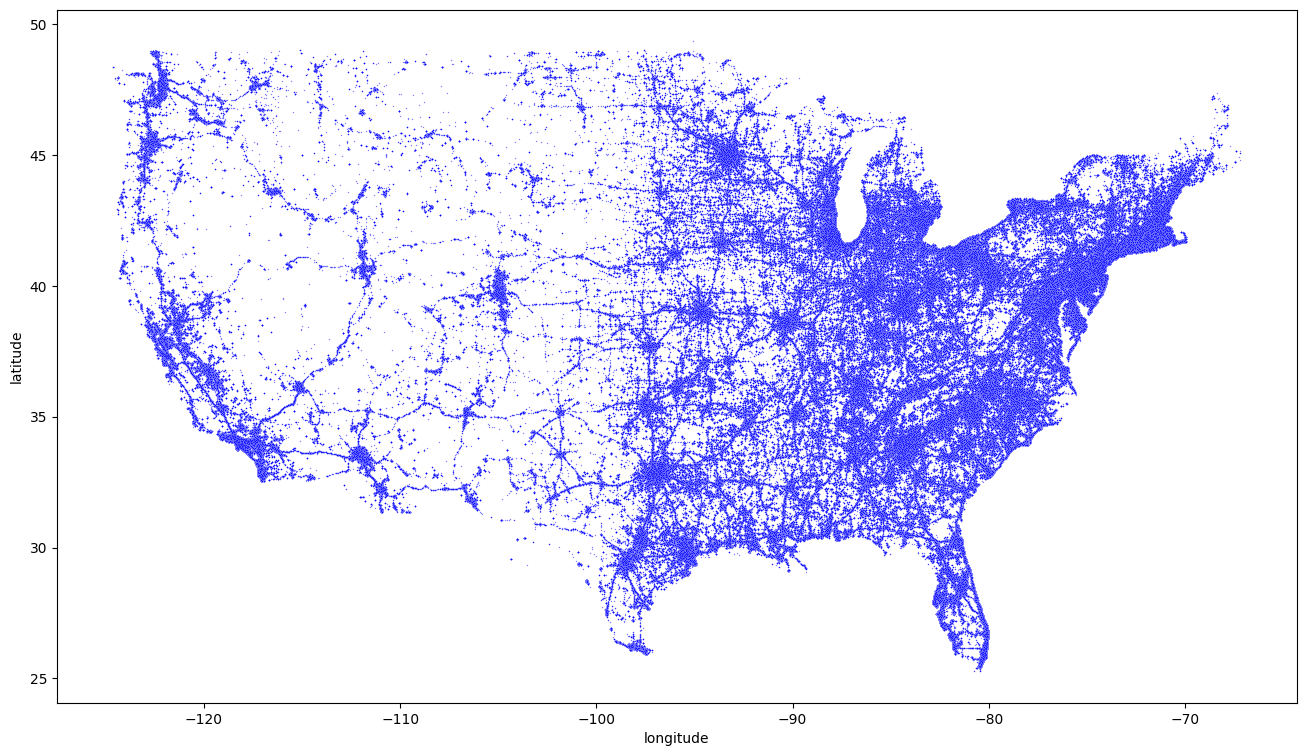

In [ ]:
fig, ax = plt.subplots(figsize=(16, 9))
sns.scatterplot(x='longitude', y='latitude', ax=ax, data=df, color='blue', s=1, alpha=0.5)
plt.show()

### There are some clear patterns:
### 1. There were more tweets during the day
### 2. Most tweets came from timezone 1 (Eastern) and 2 (Central)
### 3. There's no significant difference between days

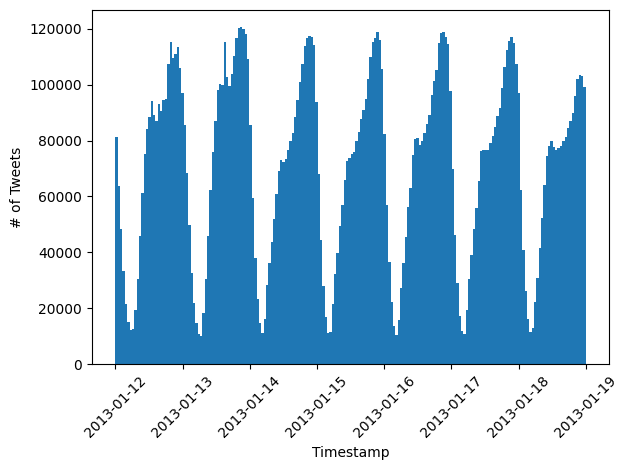

In [218]:
df['converted_timestamp'] = pd.to_datetime(df['timestamp'], format='%Y%m%d%H%M%S')
df['date'] = df['converted_timestamp'].dt.day

plt.hist(df['converted_timestamp'], bins=200)
plt.xlabel('Timestamp')
plt.ylabel('# of Tweets')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

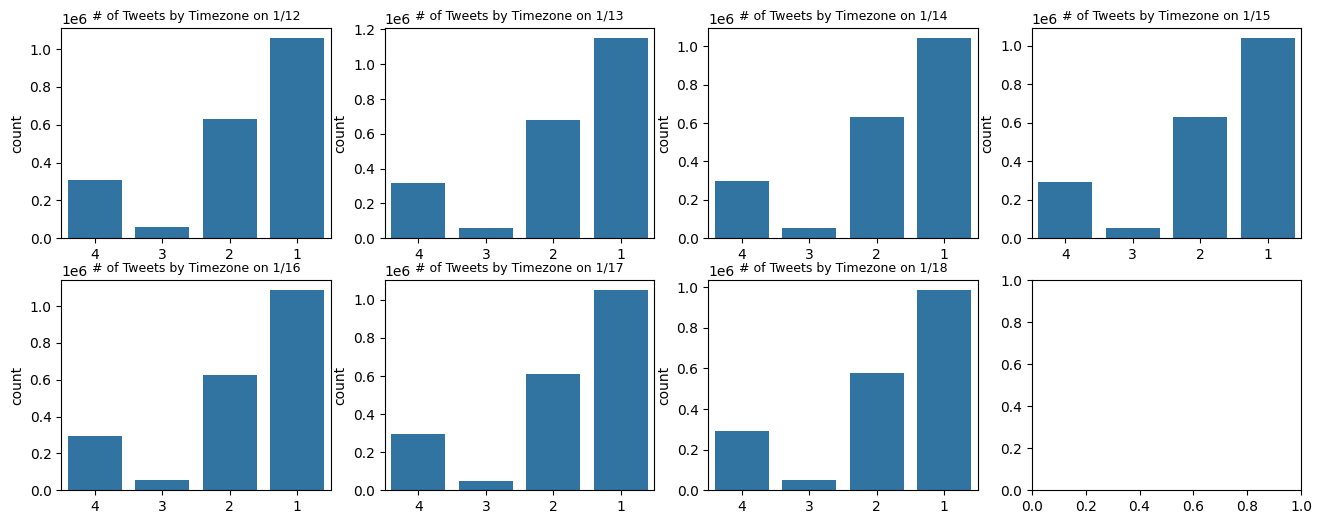

In [219]:
fig, axes = plt.subplots(2, 4, figsize=(16, 6))
axes = axes.flatten()

for d in range(12, 19):
    ax = axes[d-12]
    subset = df[df['date'] == d]
    sns.countplot(x='timezone', data=subset, ax=ax)
    ax.set_title(f"# of Tweets by Timezone on 1/{d}", fontsize=9)
    ax.set_xlabel('')
    ax.invert_xaxis()

df = df.drop(columns='date')

# Trivial Model and Metrics

### For GPS location, I will use the great circle distance (this assumes the Earth is a perfect sphere but it should be close enough)
### This metric is far more intuitive and practical than r2, rmse, etc

In [ ]:
df['long_prev'] = df['longitude'].shift(1)
df['lat_prev'] = df['latitude'].shift(1)
df['timestamp_prev'] = df['converted_timestamp'].shift(1)

def calc_dist(row):
    if pd.isnull(row['long_prev']) or pd.isnull(row['lat_prev']):
        return np.NaN
    a = (row['latitude'], row['longitude'])
    b = (row['lat_prev'], row['long_prev'])
    return great_circle(a, b).mi

df['gps_diff'] = df.apply(calc_dist, axis=1)

### gps_diff is the great circle distance (in miles) between the current point s(t) and the previous point s(t-1)
### The average "leap" is 980 miles, which is also the trivial model's "mean error"
### 980 is definitely not good enough considering the contiguous United States is approximately 2800mi x 1500mi 
### gps_diff is also right skewed, meaning there are outliers we need to address

In [437]:
df.gps_diff.describe().round(2).astype(str)

count    14262516.0
mean         980.79
std          652.09
min             0.0
25%          473.64
50%          832.67
75%         1378.55
max         2832.91
Name: gps_diff, dtype: object

<Axes: >

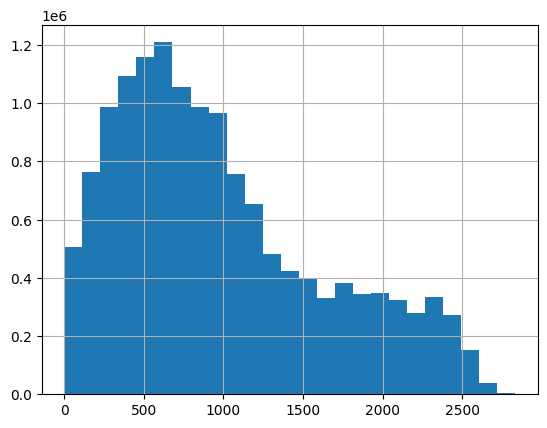

In [223]:
df['gps_diff'].hist(bins=25)

### The timestamp portion is a more standard regression problem, so I'll use MSE (Mean Squared Error) in seconds

In [224]:
df['time_diff'] = (df['converted_timestamp'] - df['timestamp_prev']).dt.total_seconds()

In [ ]:
# MSE
(df.time_diff ** 2).sum() / len(df)

0.06562383063241922

In [225]:
df.time_diff.describe().astype(str)

count             14262516.0
mean     0.04240450983543156
std       0.2526374818870739
min                      0.0
25%                      0.0
50%                      0.0
75%                      0.0
max                    574.0
Name: time_diff, dtype: object

### It's worth noting that the time difference is 0 almost 96% of the time and <= 1 99.99% of the time
### mean(time_diff) == 0.042 means the trivial model's time prediction (diff = 0) is only off by 0.042 seconds on average due to the highly skewed distribution

In [226]:
len(df[df['time_diff'] == 0])/len(df), len(df[df['time_diff'] == 1])/len(df), len(df[df['time_diff'] > 1])/len(df)

(0.9577132142945035, 0.04221078229039096, 7.593330125390911e-05)

# Training

### Since the dataset only has one week of data, skip date / day of the week feature
### I didn't use timezone bc it's highly correlated with longitude, but looking back I should've at least tested it a few times

In [ ]:
ts = df['converted_timestamp']
df['seconds_of_day'] = ts.dt.hour * 3600 + ts.dt.minute * 60 + ts.dt.second

df['t_sin'] = np.sin(2 * np.pi * df['seconds_of_day'] / 86400)
df['t_cos'] = np.cos(2 * np.pi * df['seconds_of_day'] / 86400)

In [ ]:
data = np.array(df[['longitude', 'latitude', 't_sin', 't_cos']])

### features I tried but didn't work:
### 1. calculate bearing from the previous point and split it into sin and cos
### 2. great circle distance between the current point and the previous point

In [ ]:
'''
def calc_bearing(row):

    lat1 = np.deg2rad(row['lat_prev'])
    lat2 = np.deg2rad(row['latitude'])
    dlon = np.deg2rad(row['longitude'] - row['long_prev'])

    x = np.sin(dlon) * np.cos(lat2)
    y = np.cos(lat1)*np.sin(lat2) - np.sin(lat1)*np.cos(lat2)*np.cos(dlon)
    
    bearing = np.arctan2(x, y)
    return np.rad2deg(bearing) % 360

df['bearing'] = df.apply(calc_bearing, axis=1)
df['bearing_sin'] = np.sin(df['bearing'])
df['bearing_cos'] = np.cos(df['bearing'])
'''

### For each point, use the last 15 rows' data (long, lat, time_sin, and time_cos) as X_train and the current point's long, lat as y_train

In [ ]:
WINDOW_SIZE = 15
X, y = [], []
for i in range(1, len(df) - WINDOW_SIZE):
    X.append(data[i:i+WINDOW_SIZE])
    y.append(data[i+WINDOW_SIZE][:2])
X = np.array(X)
y = np.array(y)

### 70% for training, 15% for validation, and 15% for testing

In [ ]:
int(len(X) * 0.7), int(len(X) * 0.85)

(9983751, 12123126)

In [328]:
X_train, y_train = X[:9983751], y[:9983751]
X_valid, y_valid = X[9983751:12123126], y[9983751:12123126]
X_test,  y_test  = X[12123126:], y[12123126:]

### Before I switched to xgboost regressor, I tried LSTM since it's a time series dataset
### I experimented with all sorts of combinations:
### setup: 1 / 2 layers of LSTM
### batch_size: 16, 32, 64, 512, and even 1024 bc the dataset is enormous
### features: a.) just long lat from previous points | b.) long lat + time | c.) long lat + time + bearing + distance
### window size: 5, 10, 15, 30, 60, 90, 120 (my m3 macbook pro only has enough ram for 4 features * 120 prev rows)
### data: raw / normalized

### Training LSTM took way too long and the training loss usually stopped improving after just 3-5 epochs (using just 10% of the data still takes 130s/epoch)
### All the abovementioned combinations have about the same "accuracy score." avg great_circle(y-ŷ) is around 750mi and the std is about 500mi

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

In [ ]:
'''
model = Sequential([
    LSTM(64, activation='tanh', return_sequences=True, input_shape=(WINDOW_SIZE, 4)),
    Dropout(0.2),
    LSTM(32, activation='tanh'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(2)
])


model.compile(optimizer='adam', loss='mae')
model.summary()

history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    epochs=10,
    batch_size=32,
    verbose=1
)
'''

Epoch 1/10
31200/31200 ━━━━━━━━━━━━━━━━━━━━ 126s 4ms/step - loss: 9.6727 - val_loss: 7.5620
Epoch 2/10
31200/31200 ━━━━━━━━━━━━━━━━━━━━ 130s 4ms/step - loss: 7.4082 - val_loss: 7.5754
Epoch 3/10
31200/31200 ━━━━━━━━━━━━━━━━━━━━ 130s 4ms/step - loss: 7.4029 - val_loss: 7.5613
Epoch 4/10
31200/31200 ━━━━━━━━━━━━━━━━━━━━ 129s 4ms/step - loss: 7.3937 - val_loss: 7.5545
Epoch 5/10
31200/31200 ━━━━━━━━━━━━━━━━━━━━ 127s 4ms/step - loss: 7.3875 - val_loss: 7.5642
Epoch 6/10
31200/31200 ━━━━━━━━━━━━━━━━━━━━ 127s 4ms/step - loss: 7.3977 - val_loss: 7.5718
Epoch 7/10
31200/31200 ━━━━━━━━━━━━━━━━━━━━ 130s 4ms/step - loss: 7.3885 - val_loss: 7.5640
Epoch 8/10
31200/31200 ━━━━━━━━━━━━━━━━━━━━ 134s 4ms/step - loss: 7.3870 - val_loss: 7.5776
Epoch 9/10
31200/31200 ━━━━━━━━━━━━━━━━━━━━ 135s 4ms/step - loss: 7.4000 - val_loss: 7.5631
Epoch 10/10
31200/31200 ━━━━━━━━━━━━━━━━━━━━ 135s 4ms/step - loss: 7.4014 - val_loss: 7.5658


### xgboost: flexible, no need to normalize data, can handle complex non linear relationships
### mae (mean average error) performed slightly better than mse but took 4x more time to train (11 min vs 53min)


In [141]:
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor

In [332]:
X_train = X_train.reshape(X_train.shape[0], -1)
X_valid = X_valid.reshape(X_valid.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

In [ ]:
model = XGBRegressor(max_depth=5,     
                     learning_rate=0.01,
                     min_child_weight=1,
                     n_estimators=1000,                                                                    
                     seed=1000, objective='reg:absoluteerror')

multi_output_model = MultiOutputRegressor(model)

multi_output_model.fit(X_train, y_train)

In [361]:
y_pred_val = multi_output_model.predict(X_valid)
y_pred = multi_output_model.predict(X_test)

xgboost_results_val = pd.DataFrame(
    data = np.hstack([y_valid, y_pred_val]),
    columns = [
        'actual_lon', 'actual_lat',
        'pred_lon', 'pred_lat'
    ]
)
xgboost_results = pd.DataFrame(
    data = np.hstack([y_test, y_pred]),
    columns = [
        'actual_lon', 'actual_lat',
        'pred_lon', 'pred_lat'
    ]
)

In [362]:
def calc_dist(row):
    a = (row['actual_lat'], row['actual_lon'])
    b = (row['pred_lat'], row['pred_lon'])
    return great_circle(a, b).mi

xgboost_results['gps_diff'] = xgboost_results.apply(calc_dist, axis=1)
xgboost_results_val['gps_diff'] = xgboost_results_val.apply(calc_dist, axis=1)

In [ ]:
import joblib
joblib.dump(multi_output_model, 'xgb_multi_output_model.pkl')

['xgb_multi_output_model_mse.pkl']

### Time Model
### Concept: I found that there could be up to 69 tweets in one second. Without more accurate time data, the most intuitive way to predict when it's time to "move forward" is by looking at the number of tweets we already have in this second

### I also added time sin and time cos because there are fewer tweets after midnight (more sparse)

### Since using window size = 1 makes more sense in this case, I decided to train a seperate model to save time and avoid confusing the gps model. The first couple of LSTM models I built also did a really poor job predicting long, lat, and time at the same time. 

In [ ]:
same_second_cnt = []
curr = 20130112000000
cnt = 0
for i in df.timestamp:
    if i == curr:
        cnt += 1
    else:
        curr = i
        cnt = 1

    same_second_cnt.append(cnt)

df['same_second_cnt'] = same_second_cnt

In [ ]:
time_X = np.array(df[['t_sin', 't_cos', 'same_second_cnt']].shift(1)[1:])
time_y = np.array(df.time_diff[1:])

In [ ]:
time_X_train, time_y_train = time_X[:-2139375*2], time_y[:-2139375*2]
time_X_valid, time_y_valid = time_X[-2139375*2:-2139375], time_y[-2139375*2:-2139375]
time_X_test,  time_y_test  = time_X[-2139375:], time_y[-2139375:]

In [ ]:
time_model = XGBRegressor(max_depth=8,     
                     learning_rate=0.01,
                     min_child_weight=1,
                     n_estimators=5000,                                                                    
                     seed=1000, objective='reg:squarederror')

time_model.fit(time_X_train, time_y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
             max_leaves=None, min_child_weight=1, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=5000,
             n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
joblib.dump(time_model, 'xgb_time_model.pkl')

['xgb_time_model.pkl']

In [ ]:
time_y_pred = time_model.predict(time_X_test)
time_y_pred = np.where(time_y_pred > 0, time_y_pred, 0) # t has to be greater than or equal to t-1

time_y_pred_val = time_model.predict(time_X_valid)
time_y_pred_val = np.where(time_y_pred_val > 0, time_y_pred, 0)

# Evaluation

### Spatial

In [438]:
spatial_acc = pd.DataFrame({'Trivial (on X_test)': df[-2139375:].gps_diff.describe().round(2).astype(str),
                            'Validation': xgboost_results_val.gps_diff.describe().round(2).astype(str),
                            'Test': xgboost_results.gps_diff.describe().round(2).astype(str)})
spatial_acc

,Trivial (on X_test),Validation,Test
count,2139375.0,2139375.0,2139375.0
mean,1001.06,697.91,719.56
std,659.33,508.93,513.47
min,0.0,0.43,0.66
25%,483.94,331.84,347.36
50%,854.91,541.21,565.5
75%,1423.48,833.44,862.22
max,2826.95,2244.94,2242.36


### The XGBoost model outperforms the trivial model
### It reduces average great circle distance between y and ŷ by 30% (~= 50% reduction in area). std is also lower (Table above and fig 1 below)
### There are also fewer outliers (1000-1500 and 2000+)
### However, the model still has some obvious shortcomings
### It's too "conservative" (fig 2). The ranges are narrower and they don't really match actual data.
### PS: I checked some of the LSTM models I built and they had the same issue

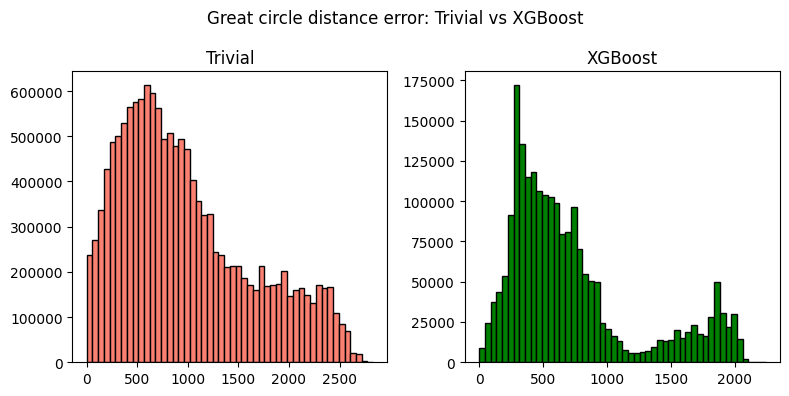

In [414]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

axs[0].hist(df.gps_diff, bins=50, color='salmon', edgecolor='black')
axs[0].set_title('Trivial')

axs[1].hist(xgboost_results.gps_diff, bins=50, color='green', edgecolor='black')
axs[1].set_title('XGBoost')

plt.suptitle("Great circle distance error: Trivial vs XGBoost")
plt.tight_layout()
plt.show()

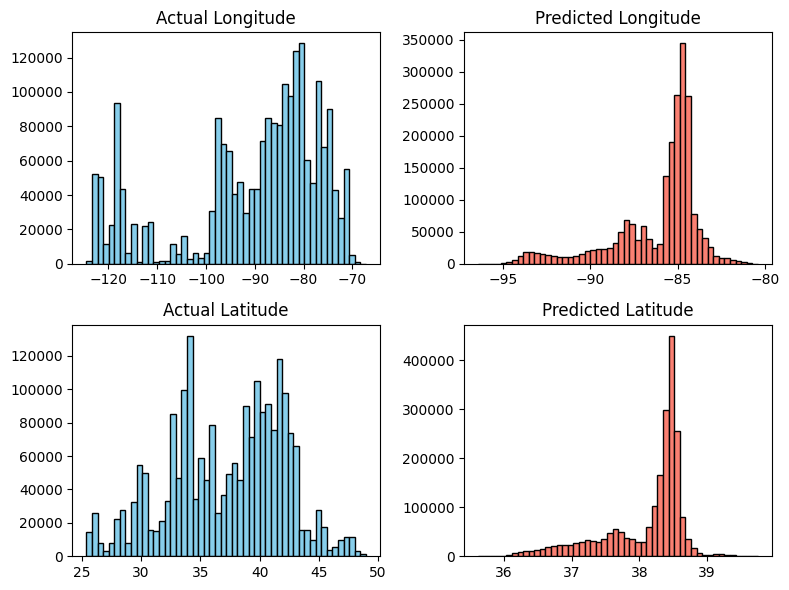

In [413]:
fig, axs = plt.subplots(2, 2, figsize=(8, 6))

axs[0, 0].hist(xgboost_results.actual_lon, bins=50, color='skyblue', edgecolor='black')
axs[0, 0].set_title('Actual Longitude')

axs[0, 1].hist(xgboost_results.pred_lon, bins=50, color='salmon', edgecolor='black')
axs[0, 1].set_title('Predicted Longitude')

axs[1, 0].hist(xgboost_results.actual_lat, bins=50, color='skyblue', edgecolor='black')
axs[1, 0].set_title('Actual Latitude')

axs[1, 1].hist(xgboost_results.pred_lat, bins=50, color='salmon', edgecolor='black')
axs[1, 1].set_title('Predicted Latitude')
plt.tight_layout()
plt.show()

### Temporal

In [ ]:
from sklearn.metrics import mean_squared_error

### Trivial MSE

In [ ]:
(df.time_diff[-2139375:] ** 2).sum() / 2139375

0.04360292141396436

### XGBoost MSE

In [ ]:
mean_squared_error(time_y_pred, time_y_test)

0.03711220623603683

### The XGBoost time model is also more "accurate" than the trivial model in terms of MSE, but it can't really predict outliers
### The model's prediction is less than 1s 99.997% of the time while the real 96th (92720 / 2139375) percentile should be 1s, and it's max output is only +1.72s
### But since the timestamp column is really dense, both the trivial model and the xgboost model should be sufficient (+- 1s) unless one's more interested in accurately predicting major time gaps (outliers)

In [419]:
df[-2139375:].groupby('time_diff').time_diff.count()

time_diff
0.0    2046518
1.0      92720
2.0        134
3.0          3
Name: time_diff, dtype: int64

In [440]:
pd.DataFrame(time_y_pred).describe().round(2).astype(str)

,0
count,2139375.0
mean,0.03
std,0.06
min,0.0
25%,0.0
50%,0.0
75%,0.04
max,1.72


In [441]:
pd.DataFrame(time_y_pred).quantile(0.96), pd.DataFrame(time_y_pred).quantile(0.99997)

(0    0.187814
 Name: 0.96, dtype: float64,
 0    1.028497
 Name: 0.99997, dtype: float64)

In [443]:
df

,longitude,latitude,timestamp,timezone,converted_timestamp,long_prev,lat_prev,timestamp_prev,gps_diff,time_diff,seconds_of_day,t_sin,t_cos,same_second_cnt
0,-87.895450,43.063007,20130112000000,2,2013-01-12 00:00:00,NaN,NaN,NaT,NaN,NaN,0,0.000000,1.0,1
1,-93.674799,45.025114,20130112000000,2,2013-01-12 00:00:00,-87.895450,43.063007,2013-01-12 00:00:00,317.333473,0.0,0,0.000000,1.0,2
2,-97.104568,32.709685,20130112000000,2,2013-01-12 00:00:00,-93.674799,45.025114,2013-01-12 00:00:00,870.464478,0.0,0,0.000000,1.0,3
3,-71.120095,42.351453,20130112000000,1,2013-01-12 00:00:00,-97.104568,32.709685,2013-01-12 00:00:00,1563.520758,0.0,0,0.000000,1.0,4
4,-79.048690,43.100826,20130112000000,1,2013-01-12 00:00:00,-71.120095,42.351453,2013-01-12 00:00:00,405.587078,0.0,0,0.000000,1.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14262512,-90.703468,42.495940,20130118235955,2,2013-01-18 23:59:55,-71.104156,42.342111,2013-01-18 23:59:55,997.525873,0.0,86395,-0.000364,1.0,8
14262513,-80.084576,37.292336,20130118235955,1,2013-01-18 23:59:55,-90.703468,42.495940,2013-01-18 23:59:55,667.149719,0.0,86395,-0.000364,1.0,9
14262514,-81.509412,41.574817,20130118235955,1,2013-01-18 23:59:55,-80.084576,37.292336,2013-01-18 23:59:55,305.491276,0.0,86395,-0.000364,1.0,10
14262515,-98.181743,26.202471,20130118235955,2,2013-01-18 23:59:55,-81.509412,41.574817,2013-01-18 23:59:55,1423.923026,0.0,86395,-0.000364,1.0,11


In [ ]:
xgboost_results['actual_time'] = np.array(df.converted_timestamp[-2139375:])
xgboost_results['prev_time'] = np.array(df.timestamp_prev[-2139375:])
xgboost_results['add_s'] = time_y_pred
xgboost_results['pred_time'] = xgboost_results['prev_time'] + pd.to_timedelta(xgboost_results['add_s'], unit='s')
xgboost_results.drop(columns=['prev_time', 'add_s'], inplace=True)

In [463]:
xgboost_results.to_csv('test_output.csv')

# Thoughts and Comments

### I should've tested different models, hyperparameters, and features more systematically
### Training on the entire dataset takes forever, but I'm still not sure if it's ok to just use 5-10% of the data to evaluate a model and jump to conclusions
### I also don't know if adding complexity (increasing window_size to 180/360, increasing xgboost n_estimator, further reducing batch_size, etc) can really improve the model. I already ran out of time and memory space testing the ones I mentioned.


### Initally I thought I could bring the mean error down to 300-500mi. Felt like I "wasted" too much time before I "gave up." I don't know if it's skill issue, the models I used, or the randomess of the dataset that made it almost impossible to do better than 700mi
### The next logical step is to focus on outliers (west coast coordinates), but it's possible that those outliers are simply too random to be learned by the model